# Notebook 1: Synthetic Evaluation Dataset

## Overview

In large-scale RAG applications, manually reviewing thousands of user queries isn't feasible. We need systematic ways to evaluate our system's performance with representative test data. By generating high-quality synthetic datasets, we can:

1. Benchmark retrieval performance across different configurations
2. Identify blind spots in our system before deploying to users
3. Create reproducible evaluation workflows for continuous improvement

This notebook walks you through creating a synthetic dataset of queries, documents, and answers based on academic papers that will help you systematically evaluate and improve your RAG Agent.

## Setup

First, let's install the necessary libraries:

In [1]:
%pip install openai llm-data-simulator chromadb sentence_transformers pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import openai
from data_simulator import DataSimulator
import getpass
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

DATA_DIR = "../data/papers"
EVAL_DIR = "../data/evalset"

/Users/tahmidtapadar/Documents/cookbooks/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We'll use OpenAI's API for generating our synthetic dataset.

In [3]:
openai.api_key = getpass.getpass('Enter your OpenAI API key: ')
generator = DataSimulator(api_key=openai.api_key)

First, we generate a set of diverse questions based on academic papers. We'll use the data_simulator library to help us generate realistic queries and answers that researchers might ask about these papers. The data_simulator library first filters out low-quality content, then generates realistic queries and answers that match how your system will actually be used.

In [5]:
results = generator.generate_from_docs(
    file_paths=[f"{DATA_DIR}/gpt_1.pdf", f"{DATA_DIR}/gpt_2.pdf", f"{DATA_DIR}/gpt_3.pdf", f"{DATA_DIR}/gpt_4.pdf"],
    context="You're an AI research assistant helping researchers understand and analyze academic papers. The researchers need to find specific information, understand methodologies, compare approaches, and extract key findings from these papers.",
    example_queries="what are the main contributions of this paper\nwhat architecture is used in this paper\nexplain the significance of figure X in this paper"
)

Generating answers: 100%|██████████| 209/209 [06:59<00:00,  2.01s/it]


Let's examine the generated questions to ensure they're diverse and realistic:

In [6]:
eval_df = pd.DataFrame(results)
print(eval_df.head())

                  id                                                                                             document                                                                                                query                                                                                               answer
0  gpt_1.pdf_chunk_0  Improving Language Understanding\nby Generative Pre-Training\nAlec Radford\nOpenAI\nalec@openai....  describe the process of generative pre-training and its impact on language understanding tasks i...  The process of generative pre-training involves training a language model on a diverse corpus of...
1  gpt_1.pdf_chunk_1  speciﬁc task. In contrast to previous approaches, we make use of task-aware input\ntransformatio...                           key findings and performance metrics on evaluated benchmarks in this paper  The key findings indicate that the approach significantly improves upon the state of the art in ...
2  gpt_1.pdf_chunk_2  The ab

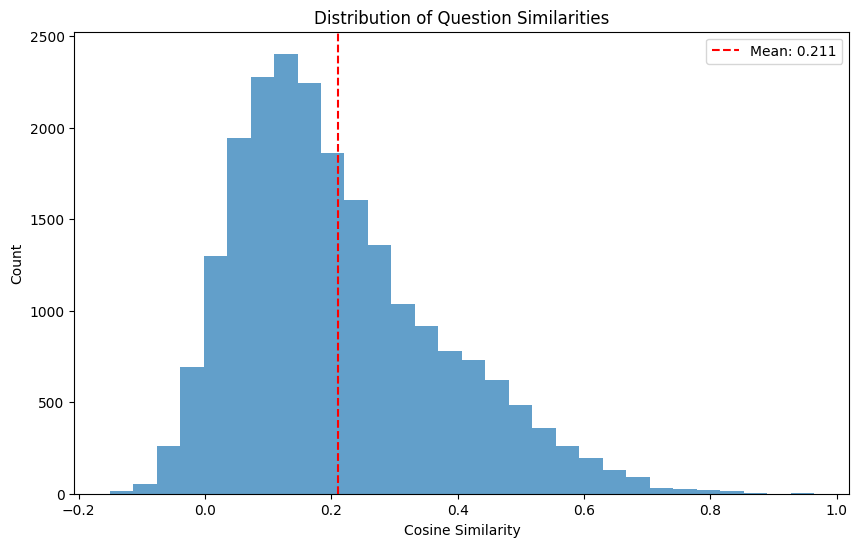

In [7]:
# Analyze semantic diversity using embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
eval_df['embedding'] = eval_df['query'].apply(lambda x: model.encode(x))

# Calculate pairwise similarities
embeddings = np.array(eval_df['embedding'].tolist())
similarities = cosine_similarity(embeddings)

# Get upper triangle values (excluding diagonal)
mask = np.triu_indices(len(similarities), k=1)
upper_tri_similarities = similarities[mask]

# Plot histogram of similarities
plt.figure(figsize=(10, 6))
plt.hist(upper_tri_similarities, bins=30, alpha=0.7)
plt.title('Distribution of Question Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.axvline(x=np.mean(upper_tri_similarities), color='r', linestyle='--', 
            label=f'Mean: {np.mean(upper_tri_similarities):.3f}')
plt.legend()
plt.show()

The histogram above shows the distribution of pairwise similarities between our generated questions. A low mean similarity of 0.226 indicates that the generated questions are diverse and not too similar. 

In [8]:
import json

# Save the full evaluation dataset
eval_file = f"{EVAL_DIR}/evalset.json"
with open(eval_file, 'w') as f:
    json.dump(results, f, indent=2)

This synthetic dataset gives us a starting point, but in practice, you'll want to continuously update your evaluation set using real user queries and feedback. While synthetic data helps us get started, real user interactions will reveal patterns we might never think to simulate. In subsequent notebooks, we'll explore how to use this dataset to evaluate and improve our RAG Agent. 